# Detect Anomalies Using Density Based Clustering


## Clustering-Based Anomaly Detection

- Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids. Normal data points occur around a dense neighborhood and abnormalities are far away.

- Using density based clustering, like DBSCAN, we can design the model such that the data points that do not fall into a cluster are the anomalies.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler


In [4]:
# Import .csv file and convert it to a DataFrame object
df = pd.read_table("curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])


In [6]:
df.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


Explore

In [7]:
# lets do a little aggregation based on the student id's in the data set,
# focusing on the number of unique hits
id_counts = df.groupby(['id'])['date', 'page', 'cohort'].nunique()

In [9]:
id_counts.head()

,date,page,cohort
id,,,
1,451,819,2
2,83,151,1
3,107,169,1
4,54,143,1
5,82,197,1


In [12]:
id_counts.date.value_counts()

1      41
2      19
3      18
5      11
4      11
       ..
108     1
209     1
74      1
164     1
451     1
Name: date, Length: 163, dtype: int64

In [ ]:
# initial questions:
# id #1 is likely a curriculum developer or someone involved on the Codeup side.
# We have some instances near the bottom of a single or < week number of page/day access
# what different values can we associate with mulitple cohort assignments?

In [15]:
# let's observe unique hits based on cohort
cohort_counts = df.groupby('cohort')['id', 'date', 'page'].nunique()

 - I want to observe the initial visit per user in this data set.
     - How am I going to do this?

In [20]:
# let's go back to our original dataframe and 
# convert to a datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    543596 non-null  object 
 1   time    543596 non-null  object 
 2   page    543595 non-null  object 
 3   id      543596 non-null  int64  
 4   cohort  515740 non-null  float64
 5   ip      543596 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 24.9+ MB


In [21]:
df['date'] = pd.to_datetime(df['date'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543596 entries, 0 to 543595
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    543596 non-null  datetime64[ns]
 1   time    543596 non-null  object        
 2   page    543595 non-null  object        
 3   id      543596 non-null  int64         
 4   cohort  515740 non-null  float64       
 5   ip      543596 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 24.9+ MB


In [24]:
first_access = df.groupby('id')['date'].min()
first_access

id
1     2018-01-26
2     2018-01-26
3     2018-01-26
4     2018-01-26
5     2018-01-26
         ...    
646   2020-04-09
647   2020-04-09
648   2020-04-22
649   2020-05-06
650   2020-05-07
Name: date, Length: 650, dtype: datetime64[ns]

In [30]:
# let's utilize that index that exists as the id, pop it back out into 
# a more columnar status, and then proceed forward with observing 
# high volume dates
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().groupby('first_access_date').count()

In [35]:
id_by_first_access_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2018-01-26 to 2020-05-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      181 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB


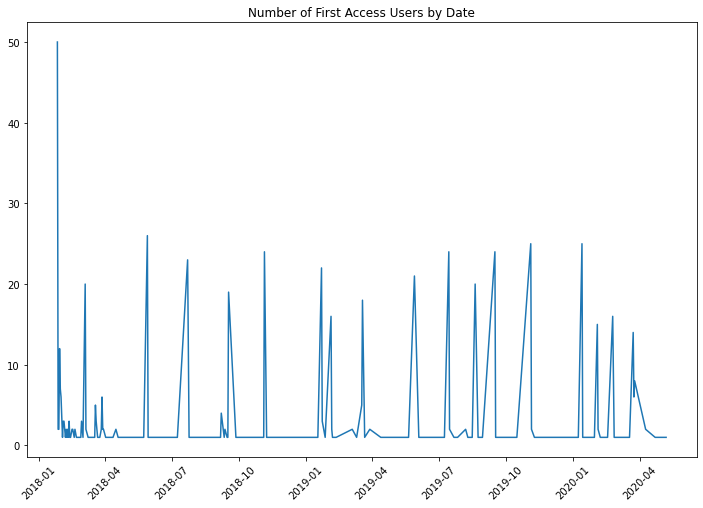

In [41]:
plt.figure(figsize=(12,8))
plt.plot(id_by_first_access_date)
plt.xticks(rotation=45)
plt.title('Number of First Access Users by Date')
plt.show()

Could someone be stealing the content of our curriculum for their benefit beyond personal education? If so, we would probably see them accessing a large number of unique pages. I would imagine they wouldn't spend much time on each page, maybe taking screen shots, copy/paste or downloading the content. Let's take a look. 

Aggregate and compute 2 features...number of unique pages and total page views. 

In [43]:
# let's make an examination:
# we want to look at individual users,
# and I want to know how they interact with pages in the curriculum,
# the number of unique pages and the number of total pages
page_views = df.groupby(['id'])['page'].agg(['count', 'nunique'])

In [44]:
page_views

,count,nunique
id,,
1,5437,819
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
646,41,23
647,10,6
648,488,130


<AxesSubplot:>

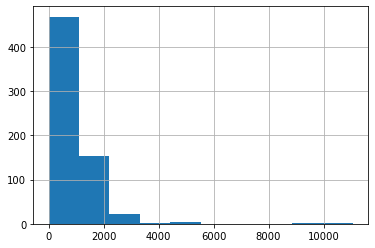

In [49]:
page_views['count'].hist()

In [50]:
# let's narrow down the scope
page_views[(page_views['count'] < 600) & (page_views['nunique'] > 190)]

,count,nunique
id,,
313,270,194


Scale each attribute linearly. 

In [51]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
scaled_page_views = scaler.transform(page_views)

In [52]:
scaled_page_views[0:5]

array([[0.49132321, 1.        ],
       [0.13919017, 0.18337408],
       [0.14108821, 0.20537897],
       [0.06245481, 0.17359413],
       [0.15365148, 0.2396088 ]])

In [53]:
scaled_cols = [col + '_scaled' for col in page_views.columns]
scaled_cols

['count_scaled', 'nunique_scaled']

In [55]:
scaled_page_views = pd.DataFrame(scaled_page_views, columns=scaled_cols, index=page_views.index)

Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.

In [56]:
dbsc = DBSCAN(eps=.1, min_samples=20)

In [57]:
dbsc

DBSCAN(eps=0.1, min_samples=20)

In [58]:
dbsc.fit(scaled_page_views)

DBSCAN(eps=0.1, min_samples=20)

In [60]:
dbsc.labels_.shape

(650,)

In [61]:
scaled_page_views.shape

(650, 2)

In [63]:
# Merge the scaled and non-scaled values into one dataframe
page_views_total = page_views.merge(scaled_page_views, on=page_views.index).drop(columns='key_0')

In [65]:
page_views_total.shape

(650, 4)

In [66]:
# let's apply the dbscan labels

In [67]:
page_views_total['labels'] = dbsc.labels_

In [68]:
page_views_total[page_views_total.labels == -1]

,count,nunique,count_scaled,nunique_scaled,labels
0,5437,819,0.491323,1.000000,-1
10,11065,698,1.000000,0.852078,-1
52,9534,303,0.861623,0.369193,-1
63,10784,373,0.974602,0.454768,-1
247,2815,456,0.254338,0.556235,-1
313,4695,181,0.424259,0.220049,-1
343,5370,215,0.485268,0.261614,-1
403,1668,352,0.150669,0.429095,-1


In [69]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views_total.describe())
print("-------------")
print("Inliers")
print(page_views_total[page_views_total.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views_total[page_views_total.labels==-1].describe())

Population
              count     nunique  count_scaled  nunique_scaled      labels
count    650.000000  650.000000    650.000000      650.000000  650.000000
mean     836.300000  116.961538      0.075497        0.141762   -0.012308
std      984.091716   76.488698      0.088945        0.093507    0.110340
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      178.000000   58.000000      0.015998        0.069682    0.000000
50%      677.500000  137.500000      0.061144        0.166870    0.000000
75%     1159.000000  159.000000      0.104664        0.193154    0.000000
max    11065.000000  819.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  count_scaled  nunique_scaled  labels
count   642.000000  642.000000    642.000000      642.000000   642.0
mean    766.708723  113.127726      0.069207        0.137075     0.0
std     666.744807   64.576135      0.060263        0.078944     0.0
min       1.000000    1.0

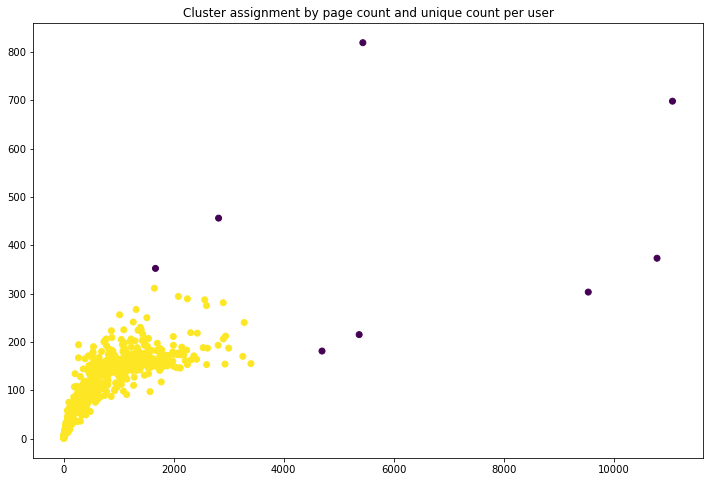

In [72]:
plt.figure(figsize=(12,8))
plt.scatter(page_views_total['count'], page_views_total['nunique'], c=page_views_total['labels'])
plt.title('Cluster assignment by page count and unique count per user')
plt.show()

## Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- Experiment with altering the epsilon values (the `eps` argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?
- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

# Exercise

**file name:** clustering_anomaly_detection.py or clustering_anomaly_detection.ipynb


### Clustering - DBSCAN

Ideas: 

Use DBSCAN to detect anomalies in curriculumn access. 

Use DBSCAN to detect anomalies in other products from the customers dataset. 

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).
